In [38]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, balanced_accuracy_score
from sklearn.ensemble import RandomForestRegressor
import xgboost
#import lightgbm as lgb

In [5]:
# import scores and predictors

features01 = pd.read_csv('predictors_processed_01.csv')
scores = pd.read_csv('scores.csv')

print(features01.info())
print(features01.describe())

print(scores.info())
print(scores.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609 entries, 0 to 1608
Data columns (total 57 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   pincode                               1609 non-null   object 
 1   living_in_households                  1609 non-null   float64
 2   living_in_communal                    1609 non-null   float64
 3   area (hectares)                       1609 non-null   float64
 4   density                               1609 non-null   float64
 5   no_emply_kids_pct                     1609 non-null   float64
 6   no_emply_no_kids_pct                  1609 non-null   float64
 7   kids_all_ages_pct                     1609 non-null   float64
 8   kids_0_4_pct                          1609 non-null   float64
 9   house_struct_other_pct                1609 non-null   float64
 10  mean age                              1609 non-null   float64
 11  median age       

/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_58318/3508424712.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


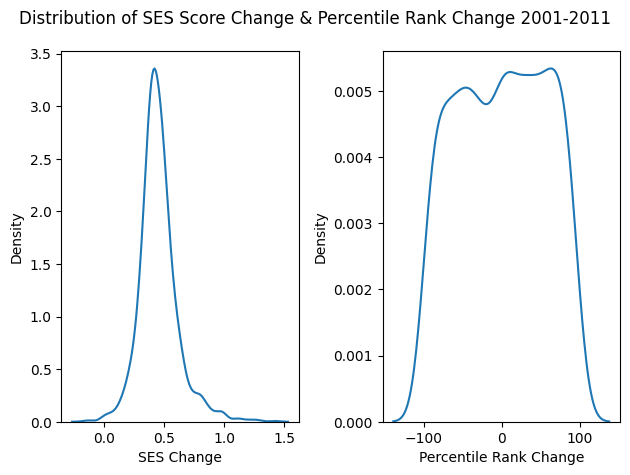

In [28]:
# look at the distribution of changes in rank and distribution of ses_asc
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.kdeplot(scores['ses_asc'], ax=ax1)
ax1.set_xlabel('SES Change')
sns.kdeplot(scores['score_pr_asc'], ax=ax2)
ax2.set_xlabel('Percentile Rank Change')
fig.suptitle('Distribution of SES Score Change & Percentile Rank Change 2001-2011')
fig.tight_layout()
fig.show()

In [6]:
# process data for modeling

# find common pincodes
common_index = features01.merge(scores, how='inner', on='pincode').index
X = features01.loc[common_index].reset_index()
y = scores.loc[common_index]['ses_asc'].reset_index()

X = X.iloc[:, 2:].values
y = y.iloc[:, 1:].values

# split data
x_train, x_test, y_train, y_test = train_test_split(X, y.squeeze(), test_size=0.25, random_state=36)

print(x_train.shape)
print(y_train.shape)

(1132, 56)
(1132,)


In [22]:
# mean and sd of ses score change

ses_mean = np.mean(y)
ses_sd = np.std(y)

ses_std_away = (y - ses_mean) / ses_sd

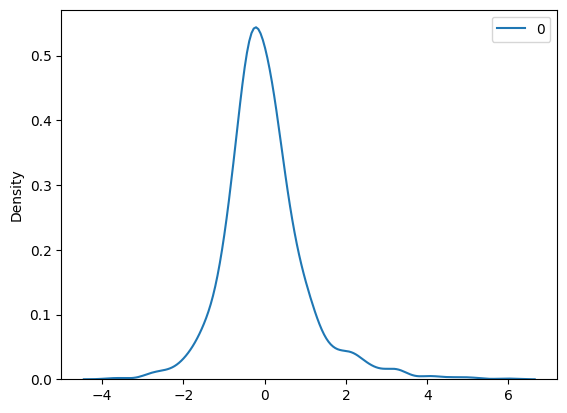

In [31]:
# distribution of sd of ses score change

sns.kdeplot(ses_std_away)
plt.show()

In [19]:
# train baseline random forest and get the metrics
untuned_rf = RandomForestRegressor(random_state=89)

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=75)

mse_untuned_rf_cv = cross_val_score(untuned_rf, x_train, y_train, cv=cv, scoring='neg_mean_squared_error')
mae_untuned_rf_cv = cross_val_score(untuned_rf, x_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

mse_untuned_rf = np.mean(np.abs(mse_untuned_rf_cv))
mae_untuned_rf = np.mean(np.abs(mae_untuned_rf_cv))

untuned_rf.fit(x_train, y_train)
y_pred = untuned_rf.predict(x_test)

print(f'Untuned RF 5-fold CV MSE: {mse_untuned_rf}\nUntuned RF 5-fold CV MAE: {mae_untuned_rf}\n')

print(f'Test MSE using untuned RF:{mean_squared_error(y_test, y_pred)}')
print(f'Test MAE using untuned RF:{mean_absolute_error(y_test, y_pred)}')

Untuned RF 5-fold CV MSE: 0.026781079264803213
Untuned RF 5-fold CV MAE: 0.1162112815732724

Test MSE using untuned RF:0.02711474458772909
Test MAE using untuned RF:0.11608070879679512


In [32]:
y_pred_mean = np.mean(y_pred)
y_pred_sd = np.std(y_pred)

pred_std_away = (y_pred - y_pred_mean) / y_pred_sd

In [35]:
true_gentrification = []
for v in y_test:
    v_sd = (v - ses_mean) / ses_sd
    if v_sd >= 1:
        true_gentrification.append(1)
    else:
        true_gentrification.append(0)
true_gentrification = np.asarray(true_gentrification)

y_pred_gentrification = []
for v in pred_std_away:
    if v >= 1:
        y_pred_gentrification.append(1)
    else:
        y_pred_gentrification.append(0)

y_pred_gentrification = np.asarray(y_pred_gentrification)
untuned_forest_balanced_accuracy = balanced_accuracy_score(true_gentrification, y_pred_gentrification)

unbalanced_accuracy = np.sum(true_gentrification == y_pred_gentrification) / len(true_gentrification)

print(f'Unbalanced Accuracy: {unbalanced_accuracy}')
print(f'Balanced Accuracy: {untuned_forest_balanced_accuracy}')

Unbalanced Accuracy: 0.8227513227513228
Balanced Accuracy: 0.6158321013048789


In [ ]:
# feature importance

#importances = untuned_rf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in untuned_rf.estimators_], axis=0)

#forest_importances = pd.Series(importances)

#fig, ax = plt.subplots()
#forest_importances.plot.bar(yerr=std, ax=ax)
#ax.set_title("Feature importances using MDI")
#ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()

In [39]:
# hyperparameter tuning setup for random forest

criterion = ['absolute_error', 'squared_error', 'friedman_mse']

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6, 8]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [40]:
# training tuned rf
rf_model = RandomForestRegressor()

# search across 100 different combinations, and use all available cores
tuned_rf = RandomizedSearchCV(estimator = rf_model, 
                               param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, 
                               random_state=386, n_jobs = -1)

# Fit the random search model
tuned_rf.fit(x_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['absolute_error',
                                                      'squared_error',
                                                      'friedman_mse'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=386, verbose=2)

In [ ]:
# checking optimal rf parameters
tuned_rf.best_params_

In [49]:
# tuned rf and predictions
optimal_rf = RandomForestRegressor(n_estimators=500,
                                   min_samples_split= 2,
                                   min_samples_leaf= 8,
                                   max_features= 'log2',
                                   max_depth= 30,
                                   criterion= 'squared_error',
                                   bootstrap= True)
optimal_rf.fit(x_train, y_train)

y_pred_tune_rf = optimal_rf.predict(x_test)

y_pred_tune_rf_mean = np.mean(y_pred_tune_rf)
y_pred_tune_rf_sd = np.std(y_pred_tune_rf)

tune_rf_pred_std_away = (y_pred_tune_rf - y_pred_tune_rf_mean) / y_pred_tune_rf_sd

tune_rf_mse = mean_squared_error(y_test, y_pred_tune_rf)
tune_rf_mae = mean_absolute_error(y_test, y_pred_tune_rf)

print(f'Tuned RF MSE: {tune_rf_mse}\nTuned RF MAE: {tune_rf_mae}')

Tuned RF MSE: 0.026506451529217774
Tuned RF MAE: 0.11380407247085976


In [50]:
y_pred_gent_tune_rf = []
for v in tune_rf_pred_std_away:
    if v >= 1:
        y_pred_gent_tune_rf.append(1)
    else:
        y_pred_gent_tune_rf.append(0)

y_pred_gent_tune_rf = np.asarray(y_pred_gent_tune_rf)
tuned_rf_balanced_accuracy = balanced_accuracy_score(true_gentrification, y_pred_gent_tune_rf)

unbalanced_accuracy_tune_rf = np.sum(true_gentrification == y_pred_gent_tune_rf) / len(true_gentrification)

print(f'Unbalanced Accuracy: {unbalanced_accuracy_tune_rf}')
print(f'Balanced Accuracy: {tuned_rf_balanced_accuracy}')

Unbalanced Accuracy: 0.8412698412698413
Balanced Accuracy: 0.6537892909944076


In [13]:
# trying untuned xgboost

xgb_untune = xgboost.XGBRegressor()

#cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=75)
# evaluate model
xgb_untuned_mse_cv = cross_val_score(xgb_untune, x_train, y_train, scoring='neg_mean_squared_error', 
                         cv=cv, n_jobs=-1)
xgb_untuned_mae_cv = cross_val_score(xgb_untune, x_train, y_train, scoring='neg_mean_absolute_error', 
                         cv=cv, n_jobs=-1)

mse_untune_xgb = np.mean(np.abs(xgb_untuned_mse_cv))
mae_untune_xgb = np.mean(np.abs(xgb_untuned_mae_cv))

xgb_untune.fit(x_train, y_train)
y_pred_xgb = xgb_untune.predict(x_test)

print(f'Untuned XGBoost 5-fold CV MSE: {mse_untune_xgb}\nUntuned XGBoost 5-fold CV MAE: {mae_untune_xgb}\n')

print(f'Test MSE using untuned XGBoost:{mean_squared_error(y_test, y_pred_xgb)}')
print(f'Test MAE using untuned XGBoost:{mean_absolute_error(y_test, y_pred_xgb)}')

Untuned XGBoost 5-fold CV MSE: 0.030955558526536635
Untuned XGBoost 5-fold CV MAE: 0.1285926680617169

Test MSE using untuned XGBoost:0.031649884903332065
Test MAE using untuned XGBoost:0.13101110866019886


In [36]:
y_pred_xgb_mean = np.mean(y_pred_xgb)
y_pred_xgb_sd = np.std(y_pred_xgb)

pred_xgb_std_away = (y_pred_xgb - y_pred_xgb_mean) / y_pred_xgb_sd

In [37]:
# accuracies for untuned xgboost

y_pred_xgb_gentrification = []
for v in pred_xgb_std_away:
    if v >= 1:
        y_pred_xgb_gentrification.append(1)
    else:
        y_pred_xgb_gentrification.append(0)

y_pred_xgb_gentrification = np.asarray(y_pred_xgb_gentrification)
untuned_xgb_balanced_accuracy = balanced_accuracy_score(true_gentrification, y_pred_xgb_gentrification)

unbalanced_accuracy_xgb = np.sum(true_gentrification == y_pred_xgb_gentrification) / len(true_gentrification)

print(f'Unbalanced Accuracy: {unbalanced_accuracy_xgb}')
print(f'Balanced Accuracy: {untuned_xgb_balanced_accuracy}')

Unbalanced Accuracy: 0.8121693121693122
Balanced Accuracy: 0.5824066336697307


In [63]:
# hyperparameter setup for xgboost

xg_max_depth = list(range(3, 10, 1))

xg_min_child_weight = [x for x in np.linspace(0, 100, 10)]

xg_subsample = [x for x in np.linspace(0.5, 1, 10)]

xg_colsample_bytree = [x for x in np.linspace(0.5, 1, 10)]

xg_eta = [x for x in np.linspace(0.01, 0.3, 20)]

xg_gamma = [x for x in np.linspace(0, 100, 20)]

xg_lambda = [x for x in np.linspace(1, 20, 10)]

xg_alpha = [x for x in np.linspace(0, 100, 20)]


random_grid_xg = {'max_depth': xg_max_depth,
                  'colsample_bytree': xg_colsample_bytree,
               'min_child_weight': xg_min_child_weight,
               'subsample': xg_subsample,
               'eta': xg_eta,
               'gamma': xg_gamma,
               'lambda': xg_lambda,
               'alpha': xg_alpha
    }


In [72]:
# training tuned xgboost
xgb = xgboost.XGBRegressor()

# search across 100 different combinations, and use all available cores
tuned_xgb = RandomizedSearchCV(estimator = xgb, 
                               param_distributions = random_grid_xg, n_iter = 2000, cv = 5, verbose=2, 
                               random_state=386, n_jobs = -1)

# Fit the random search model
tuned_xgb.fit(x_train, y_train)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
[CV] END alpha=94.73684210526316, colsample_bytree=1.0, eta=0.20842105263157895, gamma=100.0, lambda=20.0, max_depth=9, min_child_weight=0.0, subsample=0.7222222222222222; total time=   0.1s
[CV] END alpha=21.05263157894737, colsample_bytree=0.5, eta=0.3, gamma=100.0, lambda=9.444444444444445, max_depth=7, min_child_weight=77.77777777777777, subsample=0.7777777777777778; total time=   0.0s
[CV] END alpha=36.8421052631579, colsample_bytree=0.7777777777777778, eta=0.07105263157894737, gamma=10.526315789473685, lambda=1.0, max_depth=9, min_child_weight=22.22222222222222, subsample=0.5555555555555556; total time=   0.0s
[CV] END alpha=78.94736842105263, colsample_bytree=0.9444444444444444, eta=0.0863157894736842, gamma=10.526315789473685, lambda=9.444444444444445, max_depth=4, min_child_weight=77.77777777777777, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=10.526315789473685, colsample_bytree=1.0, eta=0.07

[CV] END alpha=63.15789473684211, colsample_bytree=0.7222222222222222, eta=0.16263157894736843, gamma=89.47368421052633, lambda=9.444444444444445, max_depth=7, min_child_weight=88.88888888888889, subsample=1.0; total time=   0.0s
[CV] END alpha=21.05263157894737, colsample_bytree=0.5, eta=0.3, gamma=100.0, lambda=9.444444444444445, max_depth=7, min_child_weight=77.77777777777777, subsample=0.7777777777777778; total time=   0.0s
[CV] END alpha=36.8421052631579, colsample_bytree=0.7777777777777778, eta=0.07105263157894737, gamma=10.526315789473685, lambda=1.0, max_depth=9, min_child_weight=22.22222222222222, subsample=0.5555555555555556; total time=   0.0s
[CV] END alpha=78.94736842105263, colsample_bytree=0.9444444444444444, eta=0.0863157894736842, gamma=10.526315789473685, lambda=9.444444444444445, max_depth=4, min_child_weight=77.77777777777777, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=10.526315789473685, colsample_bytree=1.0, eta=0.07105263157894737, gamma=94.7

[CV] END alpha=36.8421052631579, colsample_bytree=1.0, eta=0.20842105263157895, gamma=68.42105263157896, lambda=3.111111111111111, max_depth=3, min_child_weight=88.88888888888889, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=36.8421052631579, colsample_bytree=1.0, eta=0.20842105263157895, gamma=68.42105263157896, lambda=3.111111111111111, max_depth=3, min_child_weight=88.88888888888889, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=94.73684210526316, colsample_bytree=0.7222222222222222, eta=0.16263157894736843, gamma=68.42105263157896, lambda=11.555555555555555, max_depth=5, min_child_weight=55.55555555555556, subsample=0.6111111111111112; total time=   0.0s
[CV] END alpha=94.73684210526316, colsample_bytree=0.7222222222222222, eta=0.16263157894736843, gamma=68.42105263157896, lambda=11.555555555555555, max_depth=5, min_child_weight=55.55555555555556, subsample=0.6111111111111112; total time=   0.0s
[CV] END alpha=57.89473684210527, colsample_bytree

[CV] END alpha=63.15789473684211, colsample_bytree=0.7222222222222222, eta=0.16263157894736843, gamma=89.47368421052633, lambda=9.444444444444445, max_depth=7, min_child_weight=88.88888888888889, subsample=1.0; total time=   0.0s
[CV] END alpha=78.94736842105263, colsample_bytree=0.7222222222222222, eta=0.10157894736842105, gamma=94.73684210526316, lambda=13.666666666666668, max_depth=8, min_child_weight=22.22222222222222, subsample=0.8333333333333333; total time=   0.0s
[CV] END alpha=89.47368421052633, colsample_bytree=0.8333333333333333, eta=0.0863157894736842, gamma=78.94736842105263, lambda=15.777777777777779, max_depth=8, min_child_weight=22.22222222222222, subsample=0.8333333333333333; total time=   0.0s
[CV] END alpha=42.10526315789474, colsample_bytree=0.8888888888888888, eta=0.17789473684210527, gamma=31.578947368421055, lambda=20.0, max_depth=8, min_child_weight=66.66666666666666, subsample=0.6111111111111112; total time=   0.0s
[CV] END alpha=68.42105263157896, colsample_by

[CV] END alpha=63.15789473684211, colsample_bytree=0.9444444444444444, eta=0.02526315789473684, gamma=100.0, lambda=1.0, max_depth=8, min_child_weight=66.66666666666666, subsample=0.6111111111111112; total time=   0.0s
[CV] END alpha=63.15789473684211, colsample_bytree=0.9444444444444444, eta=0.02526315789473684, gamma=100.0, lambda=1.0, max_depth=8, min_child_weight=66.66666666666666, subsample=0.6111111111111112; total time=   0.0s
[CV] END alpha=63.15789473684211, colsample_bytree=0.9444444444444444, eta=0.02526315789473684, gamma=100.0, lambda=1.0, max_depth=8, min_child_weight=66.66666666666666, subsample=0.6111111111111112; total time=   0.0s
[CV] END alpha=0.0, colsample_bytree=0.9444444444444444, eta=0.11684210526315789, gamma=100.0, lambda=3.111111111111111, max_depth=6, min_child_weight=77.77777777777777, subsample=0.7777777777777778; total time=   0.0s
[CV] END alpha=47.36842105263158, colsample_bytree=0.7777777777777778, eta=0.2236842105263158, gamma=47.36842105263158, lamb

[CV] END alpha=57.89473684210527, colsample_bytree=0.8888888888888888, eta=0.04052631578947368, gamma=0.0, lambda=13.666666666666668, max_depth=5, min_child_weight=11.11111111111111, subsample=0.8888888888888888; total time=   0.0s
[CV] END alpha=57.89473684210527, colsample_bytree=0.8888888888888888, eta=0.04052631578947368, gamma=0.0, lambda=13.666666666666668, max_depth=5, min_child_weight=11.11111111111111, subsample=0.8888888888888888; total time=   0.0s
[CV] END alpha=57.89473684210527, colsample_bytree=0.8888888888888888, eta=0.04052631578947368, gamma=0.0, lambda=13.666666666666668, max_depth=5, min_child_weight=11.11111111111111, subsample=0.8888888888888888; total time=   0.0s
[CV] END alpha=57.89473684210527, colsample_bytree=0.8888888888888888, eta=0.04052631578947368, gamma=0.0, lambda=13.666666666666668, max_depth=5, min_child_weight=11.11111111111111, subsample=0.8888888888888888; total time=   0.0s
[CV] END alpha=57.89473684210527, colsample_bytree=0.8888888888888888, e

[CV] END alpha=89.47368421052633, colsample_bytree=1.0, eta=0.2847368421052632, gamma=36.8421052631579, lambda=15.777777777777779, max_depth=7, min_child_weight=66.66666666666666, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=68.42105263157896, colsample_bytree=0.8888888888888888, eta=0.10157894736842105, gamma=36.8421052631579, lambda=3.111111111111111, max_depth=5, min_child_weight=100.0, subsample=0.6111111111111112; total time=   0.0s
[CV] END alpha=68.42105263157896, colsample_bytree=0.8888888888888888, eta=0.10157894736842105, gamma=36.8421052631579, lambda=3.111111111111111, max_depth=5, min_child_weight=100.0, subsample=0.6111111111111112; total time=   0.0s
[CV] END alpha=68.42105263157896, colsample_bytree=0.8888888888888888, eta=0.10157894736842105, gamma=36.8421052631579, lambda=3.111111111111111, max_depth=5, min_child_weight=100.0, subsample=0.6111111111111112; total time=   0.0s
[CV] END alpha=68.42105263157896, colsample_bytree=0.8888888888888888, eta=

[CV] END alpha=21.05263157894737, colsample_bytree=0.8888888888888888, eta=0.2236842105263158, gamma=21.05263157894737, lambda=15.777777777777779, max_depth=6, min_child_weight=44.44444444444444, subsample=0.5555555555555556; total time=   0.0s
[CV] END alpha=21.05263157894737, colsample_bytree=0.8888888888888888, eta=0.2236842105263158, gamma=21.05263157894737, lambda=15.777777777777779, max_depth=6, min_child_weight=44.44444444444444, subsample=0.5555555555555556; total time=   0.0s
[CV] END alpha=21.05263157894737, colsample_bytree=0.8888888888888888, eta=0.2236842105263158, gamma=21.05263157894737, lambda=15.777777777777779, max_depth=6, min_child_weight=44.44444444444444, subsample=0.5555555555555556; total time=   0.0s
[CV] END alpha=84.21052631578948, colsample_bytree=0.9444444444444444, eta=0.1931578947368421, gamma=78.94736842105263, lambda=9.444444444444445, max_depth=8, min_child_weight=55.55555555555556, subsample=1.0; total time=   0.0s
[CV] END alpha=84.21052631578948, co

[CV] END alpha=42.10526315789474, colsample_bytree=0.5555555555555556, eta=0.25421052631578944, gamma=5.2631578947368425, lambda=13.666666666666668, max_depth=6, min_child_weight=0.0, subsample=0.6111111111111112; total time=   0.0s
[CV] END alpha=42.10526315789474, colsample_bytree=0.5555555555555556, eta=0.25421052631578944, gamma=5.2631578947368425, lambda=13.666666666666668, max_depth=6, min_child_weight=0.0, subsample=0.6111111111111112; total time=   0.0s
[CV] END alpha=42.10526315789474, colsample_bytree=0.5555555555555556, eta=0.25421052631578944, gamma=5.2631578947368425, lambda=13.666666666666668, max_depth=6, min_child_weight=0.0, subsample=0.6111111111111112; total time=   0.0s
[CV] END alpha=42.10526315789474, colsample_bytree=0.5555555555555556, eta=0.25421052631578944, gamma=5.2631578947368425, lambda=13.666666666666668, max_depth=6, min_child_weight=0.0, subsample=0.6111111111111112; total time=   0.0s
[CV] END alpha=89.47368421052633, colsample_bytree=0.777777777777777

[CV] END alpha=5.2631578947368425, colsample_bytree=1.0, eta=0.0863157894736842, gamma=57.89473684210527, lambda=15.777777777777779, max_depth=9, min_child_weight=11.11111111111111, subsample=0.8333333333333333; total time=   0.0s
[CV] END alpha=5.2631578947368425, colsample_bytree=1.0, eta=0.0863157894736842, gamma=57.89473684210527, lambda=15.777777777777779, max_depth=9, min_child_weight=11.11111111111111, subsample=0.8333333333333333; total time=   0.0s
[CV] END alpha=5.2631578947368425, colsample_bytree=1.0, eta=0.0863157894736842, gamma=57.89473684210527, lambda=15.777777777777779, max_depth=9, min_child_weight=11.11111111111111, subsample=0.8333333333333333; total time=   0.0s
[CV] END alpha=5.2631578947368425, colsample_bytree=1.0, eta=0.0863157894736842, gamma=57.89473684210527, lambda=15.777777777777779, max_depth=9, min_child_weight=11.11111111111111, subsample=0.8333333333333333; total time=   0.0s
[CV] END alpha=100.0, colsample_bytree=0.5, eta=0.25421052631578944, gamma=6

[CV] END alpha=63.15789473684211, colsample_bytree=0.5, eta=0.2236842105263158, gamma=84.21052631578948, lambda=9.444444444444445, max_depth=5, min_child_weight=11.11111111111111, subsample=0.6666666666666666; total time=   0.0s
[CV] END alpha=63.15789473684211, colsample_bytree=0.5, eta=0.2236842105263158, gamma=84.21052631578948, lambda=9.444444444444445, max_depth=5, min_child_weight=11.11111111111111, subsample=0.6666666666666666; total time=   0.0s
[CV] END alpha=36.8421052631579, colsample_bytree=0.7777777777777778, eta=0.2847368421052632, gamma=100.0, lambda=3.111111111111111, max_depth=7, min_child_weight=55.55555555555556, subsample=0.8888888888888888; total time=   0.0s
[CV] END alpha=36.8421052631579, colsample_bytree=0.7777777777777778, eta=0.2847368421052632, gamma=100.0, lambda=3.111111111111111, max_depth=7, min_child_weight=55.55555555555556, subsample=0.8888888888888888; total time=   0.0s
[CV] END alpha=36.8421052631579, colsample_bytree=0.7777777777777778, eta=0.2847

[CV] END alpha=52.631578947368425, colsample_bytree=0.8888888888888888, eta=0.05578947368421053, gamma=89.47368421052633, lambda=15.777777777777779, max_depth=6, min_child_weight=44.44444444444444, subsample=0.8333333333333333; total time=   0.1s
[CV] END alpha=52.631578947368425, colsample_bytree=0.8888888888888888, eta=0.05578947368421053, gamma=89.47368421052633, lambda=15.777777777777779, max_depth=6, min_child_weight=44.44444444444444, subsample=0.8333333333333333; total time=   0.0s
[CV] END alpha=52.631578947368425, colsample_bytree=0.8888888888888888, eta=0.05578947368421053, gamma=89.47368421052633, lambda=15.777777777777779, max_depth=6, min_child_weight=44.44444444444444, subsample=0.8333333333333333; total time=   0.0s
[CV] END alpha=26.315789473684212, colsample_bytree=0.5, eta=0.20842105263157895, gamma=68.42105263157896, lambda=13.666666666666668, max_depth=8, min_child_weight=88.88888888888889, subsample=0.8888888888888888; total time=   0.0s
[CV] END alpha=5.2631578947

[CV] END alpha=42.10526315789474, colsample_bytree=0.6111111111111112, eta=0.1473684210526316, gamma=84.21052631578948, lambda=20.0, max_depth=7, min_child_weight=11.11111111111111, subsample=0.5555555555555556; total time=   0.0s
[CV] END alpha=21.05263157894737, colsample_bytree=0.7222222222222222, eta=0.20842105263157895, gamma=100.0, lambda=20.0, max_depth=8, min_child_weight=33.33333333333333, subsample=0.6111111111111112; total time=   0.0s
[CV] END alpha=73.6842105263158, colsample_bytree=0.5, eta=0.1931578947368421, gamma=0.0, lambda=11.555555555555555, max_depth=8, min_child_weight=100.0, subsample=0.5; total time=   0.0s
[CV] END alpha=73.6842105263158, colsample_bytree=0.5, eta=0.1931578947368421, gamma=0.0, lambda=11.555555555555555, max_depth=8, min_child_weight=100.0, subsample=0.5; total time=   0.0s
[CV] END alpha=73.6842105263158, colsample_bytree=0.5, eta=0.1931578947368421, gamma=0.0, lambda=11.555555555555555, max_depth=8, min_child_weight=100.0, subsample=0.5; tota

[CV] END alpha=31.578947368421055, colsample_bytree=0.7777777777777778, eta=0.2236842105263158, gamma=47.36842105263158, lambda=3.111111111111111, max_depth=4, min_child_weight=55.55555555555556, subsample=0.8888888888888888; total time=   0.0s
[CV] END alpha=31.578947368421055, colsample_bytree=0.7777777777777778, eta=0.2236842105263158, gamma=47.36842105263158, lambda=3.111111111111111, max_depth=4, min_child_weight=55.55555555555556, subsample=0.8888888888888888; total time=   0.0s
[CV] END alpha=31.578947368421055, colsample_bytree=0.7777777777777778, eta=0.2236842105263158, gamma=47.36842105263158, lambda=3.111111111111111, max_depth=4, min_child_weight=55.55555555555556, subsample=0.8888888888888888; total time=   0.1s
[CV] END alpha=31.578947368421055, colsample_bytree=0.7777777777777778, eta=0.2236842105263158, gamma=47.36842105263158, lambda=3.111111111111111, max_depth=4, min_child_weight=55.55555555555556, subsample=0.8888888888888888; total time=   0.1s
[CV] END alpha=31.57

[CV] END alpha=52.631578947368425, colsample_bytree=0.5555555555555556, eta=0.1931578947368421, gamma=15.789473684210527, lambda=5.222222222222222, max_depth=6, min_child_weight=11.11111111111111, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=52.631578947368425, colsample_bytree=0.5555555555555556, eta=0.1931578947368421, gamma=15.789473684210527, lambda=5.222222222222222, max_depth=6, min_child_weight=11.11111111111111, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=52.631578947368425, colsample_bytree=0.5555555555555556, eta=0.1931578947368421, gamma=15.789473684210527, lambda=5.222222222222222, max_depth=6, min_child_weight=11.11111111111111, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=52.631578947368425, colsample_bytree=0.5555555555555556, eta=0.1931578947368421, gamma=15.789473684210527, lambda=5.222222222222222, max_depth=6, min_child_weight=11.11111111111111, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=0

[CV] END alpha=5.2631578947368425, colsample_bytree=0.5, eta=0.05578947368421053, gamma=10.526315789473685, lambda=7.333333333333334, max_depth=3, min_child_weight=0.0, subsample=1.0; total time=   0.0s
[CV] END alpha=84.21052631578948, colsample_bytree=0.6111111111111112, eta=0.17789473684210527, gamma=57.89473684210527, lambda=15.777777777777779, max_depth=3, min_child_weight=55.55555555555556, subsample=0.7777777777777778; total time=   0.0s
[CV] END alpha=84.21052631578948, colsample_bytree=0.6111111111111112, eta=0.17789473684210527, gamma=57.89473684210527, lambda=15.777777777777779, max_depth=3, min_child_weight=55.55555555555556, subsample=0.7777777777777778; total time=   0.0s
[CV] END alpha=84.21052631578948, colsample_bytree=0.6111111111111112, eta=0.17789473684210527, gamma=57.89473684210527, lambda=15.777777777777779, max_depth=3, min_child_weight=55.55555555555556, subsample=0.7777777777777778; total time=   0.0s
[CV] END alpha=68.42105263157896, colsample_bytree=0.666666

[CV] END alpha=0.0, colsample_bytree=0.5555555555555556, eta=0.11684210526315789, gamma=42.10526315789474, lambda=1.0, max_depth=8, min_child_weight=88.88888888888889, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=0.0, colsample_bytree=0.5555555555555556, eta=0.11684210526315789, gamma=42.10526315789474, lambda=1.0, max_depth=8, min_child_weight=88.88888888888889, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=57.89473684210527, colsample_bytree=0.7777777777777778, eta=0.20842105263157895, gamma=31.578947368421055, lambda=11.555555555555555, max_depth=8, min_child_weight=88.88888888888889, subsample=0.5; total time=   0.0s
[CV] END alpha=57.89473684210527, colsample_bytree=0.7777777777777778, eta=0.20842105263157895, gamma=31.578947368421055, lambda=11.555555555555555, max_depth=8, min_child_weight=88.88888888888889, subsample=0.5; total time=   0.0s
[CV] END alpha=57.89473684210527, colsample_bytree=0.7777777777777778, eta=0.20842105263157895, gamma=

[CV] END alpha=63.15789473684211, colsample_bytree=0.7777777777777778, eta=0.20842105263157895, gamma=42.10526315789474, lambda=9.444444444444445, max_depth=3, min_child_weight=33.33333333333333, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=63.15789473684211, colsample_bytree=0.7777777777777778, eta=0.20842105263157895, gamma=42.10526315789474, lambda=9.444444444444445, max_depth=3, min_child_weight=33.33333333333333, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=63.15789473684211, colsample_bytree=0.7777777777777778, eta=0.20842105263157895, gamma=42.10526315789474, lambda=9.444444444444445, max_depth=3, min_child_weight=33.33333333333333, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=63.15789473684211, colsample_bytree=0.7777777777777778, eta=0.20842105263157895, gamma=42.10526315789474, lambda=9.444444444444445, max_depth=3, min_child_weight=33.33333333333333, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=63.15

[CV] END alpha=89.47368421052633, colsample_bytree=1.0, eta=0.3, gamma=15.789473684210527, lambda=17.88888888888889, max_depth=3, min_child_weight=66.66666666666666, subsample=0.7222222222222222; total time=   0.0s
[CV] END alpha=89.47368421052633, colsample_bytree=1.0, eta=0.3, gamma=15.789473684210527, lambda=17.88888888888889, max_depth=3, min_child_weight=66.66666666666666, subsample=0.7222222222222222; total time=   0.0s
[CV] END alpha=89.47368421052633, colsample_bytree=1.0, eta=0.3, gamma=15.789473684210527, lambda=17.88888888888889, max_depth=3, min_child_weight=66.66666666666666, subsample=0.7222222222222222; total time=   0.0s
[CV] END alpha=68.42105263157896, colsample_bytree=0.7777777777777778, eta=0.2847368421052632, gamma=15.789473684210527, lambda=15.777777777777779, max_depth=6, min_child_weight=0.0, subsample=0.6666666666666666; total time=   0.0s
[CV] END alpha=36.8421052631579, colsample_bytree=0.5, eta=0.07105263157894737, gamma=78.94736842105263, lambda=9.444444444

[CV] END alpha=26.315789473684212, colsample_bytree=0.8333333333333333, eta=0.16263157894736843, gamma=0.0, lambda=13.666666666666668, max_depth=6, min_child_weight=0.0, subsample=0.7222222222222222; total time=   0.0s
[CV] END alpha=0.0, colsample_bytree=1.0, eta=0.23894736842105263, gamma=47.36842105263158, lambda=13.666666666666668, max_depth=3, min_child_weight=55.55555555555556, subsample=0.5555555555555556; total time=   0.0s
[CV] END alpha=0.0, colsample_bytree=1.0, eta=0.23894736842105263, gamma=47.36842105263158, lambda=13.666666666666668, max_depth=3, min_child_weight=55.55555555555556, subsample=0.5555555555555556; total time=   0.0s
[CV] END alpha=0.0, colsample_bytree=1.0, eta=0.23894736842105263, gamma=47.36842105263158, lambda=13.666666666666668, max_depth=3, min_child_weight=55.55555555555556, subsample=0.5555555555555556; total time=   0.0s
[CV] END alpha=73.6842105263158, colsample_bytree=0.9444444444444444, eta=0.11684210526315789, gamma=5.2631578947368425, lambda=11

[CV] END alpha=52.631578947368425, colsample_bytree=0.9444444444444444, eta=0.0863157894736842, gamma=10.526315789473685, lambda=1.0, max_depth=4, min_child_weight=88.88888888888889, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=100.0, colsample_bytree=0.6666666666666666, eta=0.17789473684210527, gamma=21.05263157894737, lambda=17.88888888888889, max_depth=4, min_child_weight=100.0, subsample=0.8333333333333333; total time=   0.0s
[CV] END alpha=100.0, colsample_bytree=0.6666666666666666, eta=0.17789473684210527, gamma=21.05263157894737, lambda=17.88888888888889, max_depth=4, min_child_weight=100.0, subsample=0.8333333333333333; total time=   0.0s
[CV] END alpha=100.0, colsample_bytree=0.6666666666666666, eta=0.17789473684210527, gamma=21.05263157894737, lambda=17.88888888888889, max_depth=4, min_child_weight=100.0, subsample=0.8333333333333333; total time=   0.0s
[CV] END alpha=100.0, colsample_bytree=0.6666666666666666, eta=0.17789473684210527, gamma=21.052631578947

[CV] END alpha=31.578947368421055, colsample_bytree=0.6111111111111112, eta=0.1931578947368421, gamma=5.2631578947368425, lambda=9.444444444444445, max_depth=8, min_child_weight=88.88888888888889, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=31.578947368421055, colsample_bytree=0.6111111111111112, eta=0.1931578947368421, gamma=5.2631578947368425, lambda=9.444444444444445, max_depth=8, min_child_weight=88.88888888888889, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=31.578947368421055, colsample_bytree=0.6111111111111112, eta=0.1931578947368421, gamma=5.2631578947368425, lambda=9.444444444444445, max_depth=8, min_child_weight=88.88888888888889, subsample=0.9444444444444444; total time=   0.0s
[CV] END alpha=57.89473684210527, colsample_bytree=1.0, eta=0.13210526315789473, gamma=94.73684210526316, lambda=7.333333333333334, max_depth=8, min_child_weight=22.22222222222222, subsample=0.6111111111111112; total time=   0.0s
[CV] END alpha=57.89473684210527

[CV] END alpha=84.21052631578948, colsample_bytree=0.7222222222222222, eta=0.10157894736842105, gamma=15.789473684210527, lambda=20.0, max_depth=7, min_child_weight=55.55555555555556, subsample=0.5555555555555556; total time=   0.0s
[CV] END alpha=57.89473684210527, colsample_bytree=0.8333333333333333, eta=0.07105263157894737, gamma=89.47368421052633, lambda=20.0, max_depth=3, min_child_weight=88.88888888888889, subsample=0.5; total time=   0.0s
[CV] END alpha=57.89473684210527, colsample_bytree=0.8333333333333333, eta=0.07105263157894737, gamma=89.47368421052633, lambda=20.0, max_depth=3, min_child_weight=88.88888888888889, subsample=0.5; total time=   0.0s
[CV] END alpha=57.89473684210527, colsample_bytree=0.8333333333333333, eta=0.07105263157894737, gamma=89.47368421052633, lambda=20.0, max_depth=3, min_child_weight=88.88888888888889, subsample=0.5; total time=   0.0s
[CV] END alpha=57.89473684210527, colsample_bytree=0.8333333333333333, eta=0.07105263157894737, gamma=89.47368421052

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                                             11.11111111111111,
                                                             22.22222222222222,
                                                             33.33333333333333,
                                                             44.44444444444444,
                                                             55.55555555555556,
                                                             66.66666666666666,
                                                             77.77777777777777,
                                                             88.88888888888889,
                                                             100.0],
                                        'subsample': [0.5, 0.5555555555555556,
                                                      0.6111111111111112,
                                                      0.6666666666666666,
                                                      0.7222222222222222,
                                                      0.7777777777777778,
                                                      0.8333333333333333,
                                                      0.8888888888888888,
                                                      0.9444444444444444,
                                                      1.0]},
                   random_state=386, verbose=2)

In [69]:
tuned_xgb.best_params_

{'subsample': 0.5,
 'min_child_weight': 33.33333333333333,
 'max_depth': 7,
 'lambda': 15.777777777777779,
 'gamma': 78.94736842105263,
 'eta': 0.25421052631578944,
 'colsample_bytree': 0.7777777777777778,
 'alpha': 5.2631578947368425}

In [70]:
# predictions using optimal XGBoost and checking MSE and MAE

xgb_optimal_pred = tuned_xgb.predict(x_test)

xgb_optimal_pred_mean = np.mean(xgb_optimal_pred)
xgb_optimal_pred_sd = np.std(xgb_optimal_pred)

xgb_optimal_pred_std_away = (xgb_optimal_pred - xgb_optimal_pred_mean) / xgb_optimal_pred_sd

xgb_optimal_mse = mean_squared_error(y_test, xgb_optimal_pred)
xgb_optimal_mae = mean_absolute_error(y_test, xgb_optimal_pred)

print(f'Tuned XGB MSE: {xgb_optimal_mse}\nTuned XGB MAE: {xgb_optimal_mae}')

Tuned XGB MSE: 0.027822579925797522
Tuned XGB MAE: 0.1174469447918647


/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_58318/1619223524.py:8: RuntimeWarning: invalid value encountered in divide
  xgb_optimal_pred_std_away = (xgb_optimal_pred - xgb_optimal_pred_mean) / xgb_optimal_pred_sd


In [71]:
y_pred_gent_opt_xgb = []
for v in xgb_optimal_pred_std_away:
    if v >= 1:
        y_pred_gent_opt_xgb.append(1)
    else:
        y_pred_gent_opt_xgb.append(0)

y_pred_gent_opt_xgb = np.asarray(y_pred_gent_opt_xgb)
opt_xgb_balanced_accuracy = balanced_accuracy_score(true_gentrification, y_pred_gent_opt_xgb)

unbalanced_accuracy_opt_xgb = np.sum(true_gentrification == y_pred_gent_opt_xgb) / len(true_gentrification)

print(f'Unbalanced Accuracy: {unbalanced_accuracy_opt_xgb}')
print(f'Balanced Accuracy: {opt_xgb_balanced_accuracy}')

Unbalanced Accuracy: 0.8756613756613757
Balanced Accuracy: 0.5
